In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [3]:
%time
print(1)

CPU times: total: 0 ns
Wall time: 0 ns
1


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results

import numpy as np
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load model

In [5]:
from config import mod7_params
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'))
plot_vars = ['Y', 'C', 'L', 'w', 'r', 'pi']

Model Building Complete.
Found:
	25 equations
	25 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	5 stochastic shocks
		 0 / 5 has a defined prior. 
	18 parameters
		 0 / 18 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [6]:
# assign parameters
mod.free_param_dict.update(mod7_params)
# mod.free_param_dict

Solve

In [8]:
%time mod.steady_state()

Steady state found! Sum of squared residuals is 2.3034213894186284e-23
CPU times: total: 516 ms
Wall time: 706 ms


In [9]:
# steady state values
mod.print_steady_state()

C_ss                         2.019
Div_ss                       1.453
I_ss                         0.188
K_ss                         7.523
LHS_ss                       2.323
LHS_w_ss                     0.530
L_ss                         0.451
RHS_ss                       1.452
RHS_w_ss                     0.530
TC_ss                        0.246
U_ss                      -104.511
Y_ss                         1.207
lambda_ss                    0.496
mc_ss                        0.625
pi_obj_ss                    1.000
pi_ss                        1.000
pi_star_ss                   1.000
q_ss                         0.496
r_G_ss                       1.010
r_ss                         0.035
shock_energy_ss              1.000
shock_preference_ss          1.000
shock_technology_ss          1.000
w_ss                         1.088
w_star_ss                    1.088


In addition, the following parameter values were calibrated:
phi_pi                       0.000
phi_pi_obj                 

In [10]:
mod.solve_model(solver="cycle_reduction")

Solution found, sum of squared residuals:  5.233950627320991e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [11]:
mod.check_bk_condition()
;

Model solution has 14 eigenvalues greater than one in modulus and 11 forward-looking variables.
Blanchard-Kahn condition is satisfied.


''

In [12]:
# policy matrix
for name, policy_matrix in zip(["T"], [round(mod.T, 5), round(mod.R, 5)]):
    print(name.center(10).center(50, "="))
    print(policy_matrix.to_string())

====================    T     ====================
                        C  Div        I        K    L  LHS  LHS_w  RHS  RHS_w   TC    U        Y  lambda   mc   pi   pi_obj  pi_star    q    r       r_G  shock_energy  shock_preference  shock_technology        w  w_star
C                 0.48132  0.0 -0.00160  0.09720  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.00665     0.0  0.0  0.0  0.50064      0.0  0.0  0.0  -1.19699       0.10310           0.10620           0.19939 -0.05642     0.0
Div               0.02791 -0.0  0.00288  0.23707 -0.0 -0.0   -0.0 -0.0   -0.0 -0.0 -0.0 -0.00019    -0.0 -0.0 -0.0 -0.02129     -0.0 -0.0 -0.0   0.03482       0.62319          -0.00248           0.65202 -0.37577    -0.0
I                -0.02351  0.0  0.89786 -0.08097  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.00866     0.0  0.0  0.0  0.73632      0.0  0.0  0.0  -1.55806       0.05701          -0.10731           0.36869 -0.10172     0.0
K                -0.00059  0.0  0.02245  0.97298  0.0  0.0    0.0  0.

Model stats

''

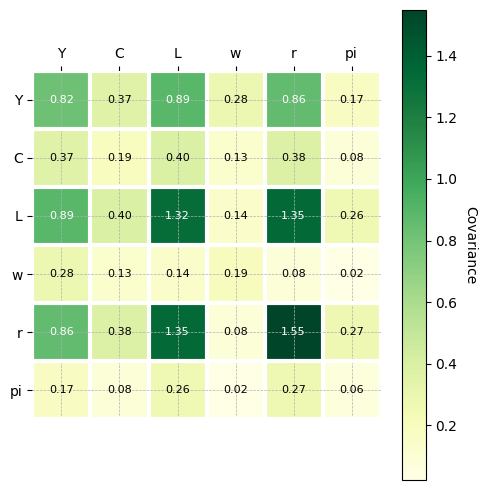

In [13]:
scov = mod.compute_stationary_covariance_matrix()
gp.plot_covariance_matrix(scov, plot_vars,
                          figsize=(5,5))
;

''

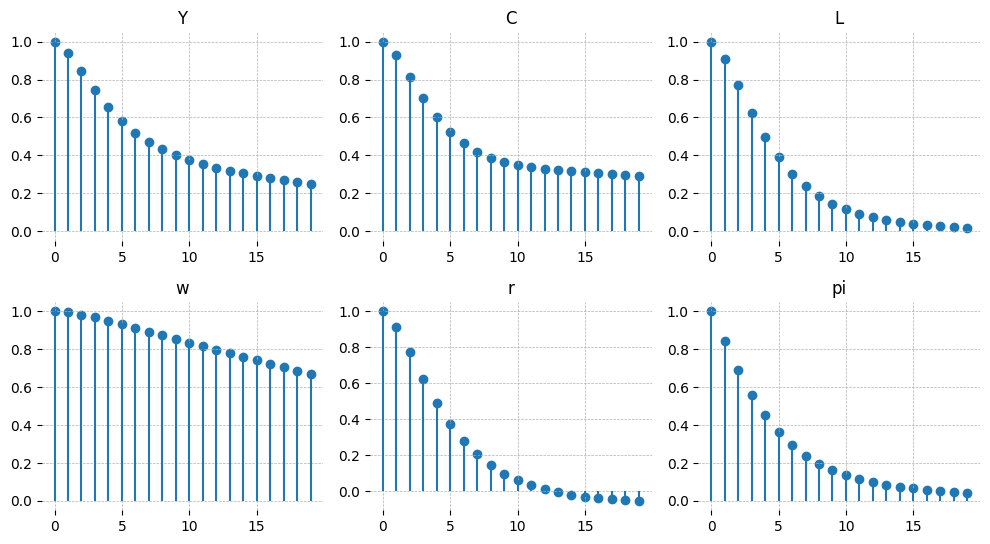

In [14]:
acorr = mod.compute_autocorrelation_matrix(n_lags=20)
gp.plot_acf(acorr, plot_vars, n_cols=3, figsize=(10, 8))
;

IRF

In [15]:
irf = mod.impulse_response_function(simulation_length=120, shock_size=.1)
shocks = list(set([item[1] for item in irf.unstack().index]))
print(f'Shocks are: {shocks}')
_irf1 = irf.copy().unstack().loc[:, "epsilon_pi"].unstack()
_irf2 = irf.copy().unstack().loc[:, "epsilon_Y"].unstack()
_irf3 = irf.copy().unstack().loc[:, "epsilon_R"].unstack()
_irf4 = irf.copy().unstack().loc[:, "epsilon_preference"].unstack()

Shocks are: ['epsilon_Y', 'epsilon_T', 'epsilon_R', 'epsilon_pi', 'epsilon_preference']


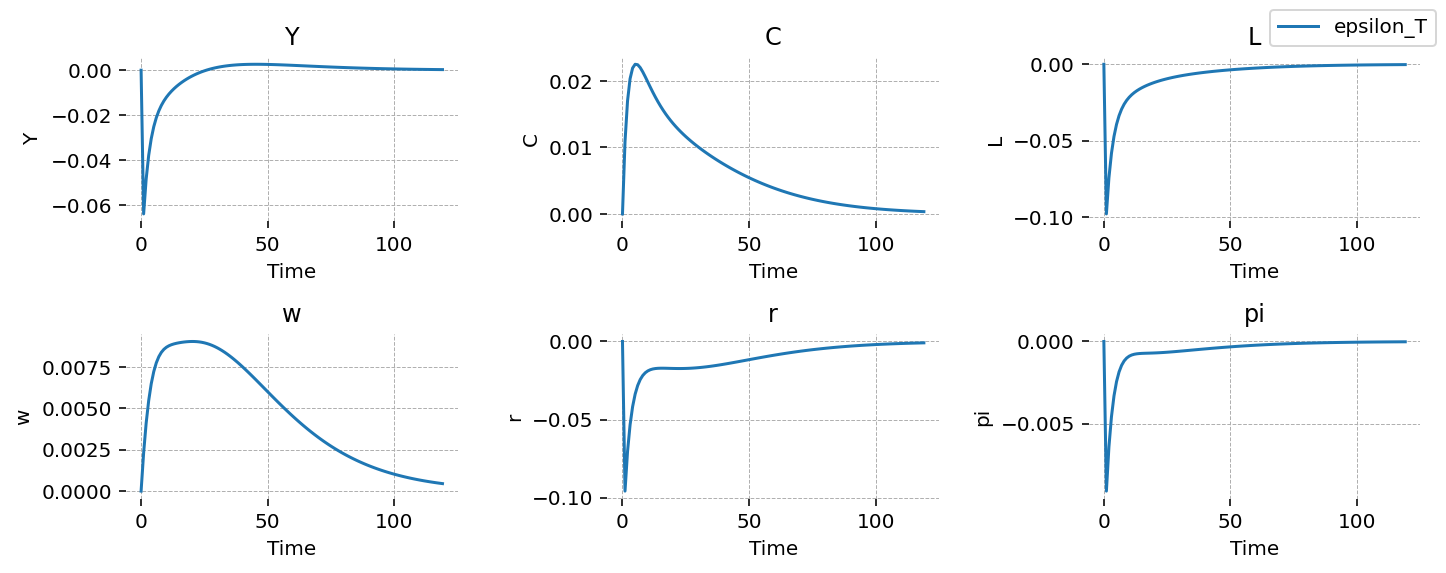

In [19]:
shocks = ['epsilon_T']
plot_dfs([irf.copy().unstack().loc[:, item].unstack()[plot_vars] for item in shocks],
         sns.lineplot,
         figsize=(10, 2),
         legend=shocks)